### Text classification of Stack Overflow Questions
In this notebook, I explored multi-class classification of text. The dataset contains questions/posts about computing languages and labels indicating which language each post is about (e.g. Python, C++). I practiced the following:
1. Preprocessing posts
2. Building pipelines to get tf-idf vectors and fit different classifiers
3. Tuning hyperparameters of different classifiers

In [71]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import html
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, roc_curve

In [3]:
df = pd.read_csv('stack-overflow-data.csv')

In [4]:
df.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


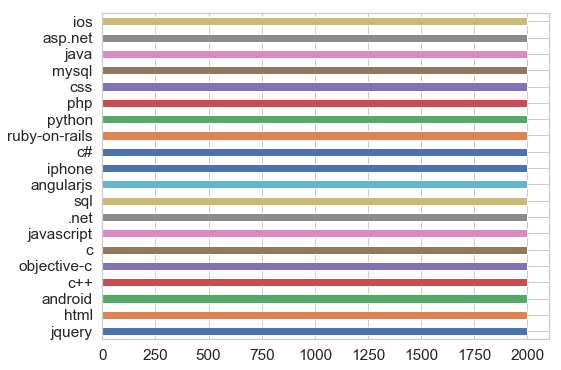

In [5]:
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(8, 6))
df['tags'].value_counts().plot(kind='barh')
plt.show()

#### example posts and tags

In [11]:
# print n-th post belonging to a particular tag
def example_data(tag, column, index):
    posts = df.loc[df['tags']==tag][column].reset_index(drop=True)
    example = posts[index]
    print("Example post with a '{}' tag:\n".format(tag), example)

In [12]:
example_data('python', 'post', 0)

Example post with a 'python' tag:
 trying to calculate and print the mean and its returning as a <function at> rather than a number  python  i have my program in python and i have used an external file with numbers in  i created a list for the numbers to be stored in and then i need to find the mean  standard deviation and the length of the list from this  at the moment my program looks like this:   <pre><code>data = open(  gauss.dat    r  ) numbers=[]  for line in data:      numbers.append(line)  sorted(numbers)  def length(numbers):     length = len(numbers)     return length  def mean(numbers):     sum = 0     for element in numbers:         sum += element      mean = sum/length     return (mean)  def main():     global history      print (length)     print( the smallest number is   + numbers[0])     print ( the largest number is   + numbers[-1])     print(mean)         return true  if __name__ ==  __main__ :      main() </code></pre>   when i run the program    <ol> <li>it doesn t 

In [13]:
c = example_data('c++', 'post', 100)

Example post with a 'c++' tag:
 how to creating function with given code in c++   giving that a function creatcustomer() that create a customer. prototype:   <pre><code>customer*creatcustomer(const string&amp;name  const string&amp;id  const string&amp;pin) </code></pre>   and the given code is like below.the structure is done by myself.    the question is how to create a function by using this given code and prototype.   <pre><code>#include &lt;iostream&gt; #include &lt;iomanip&gt; #include &lt;string&gt; using namespace std;  struct customer { string customername; string userid; string pin; }; int main() { customer* mary = createcustomer( mary jones    235718    5074 ); customer* john = createcustomer( john smith    375864    3251 ); } </code></pre>


#### preprocess posts

In [9]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_preprocess(text):
    #text = re.sub(r'<[^>]+>', '', text) # remove html tags
    text = BeautifulSoup(text, "lxml").text # remove html tags eg. <strong> </strong>
    text = html.unescape(text) # unescape html escape characters eg. &lt, &gt
    text = text.lower()
    text = re.sub(r'[^a-z#+-]', ' ', text) # remove symbols other than letters, #, - and +
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop and len(w)>1]
    
    return ' '.join(tokens)

In [10]:
df['post_cleaned'] = df['post'].apply(text_preprocess)

In [14]:
example_data('python', 'post_cleaned', 0)

Example post with a 'python' tag:
 trying calculate print mean returning rather number python program python used external file number created list number stored need find mean standard deviation length list moment program look like data open gauss dat number line data number append line sorted number def length number length len number return length def mean number sum element number sum element mean sum length return mean def main global history print length print smallest number number print largest number number print mean return true name main main run program sort number correctly new python know obvious error print mean length function length function mean idea change number hope help


In [15]:
example_data('c++', 'post_cleaned', 100)

Example post with a 'c++' tag:
 creating function given code c++ giving function creatcustomer create customer prototype customer creatcustomer const string name const string id const string pin given code like structure done question create function using given code prototype #include iostream #include iomanip #include string using namespace std struct customer string customername string userid string pin int main customer mary createcustomer mary jones customer john createcustomer john smith


#### common words in posts with different tags

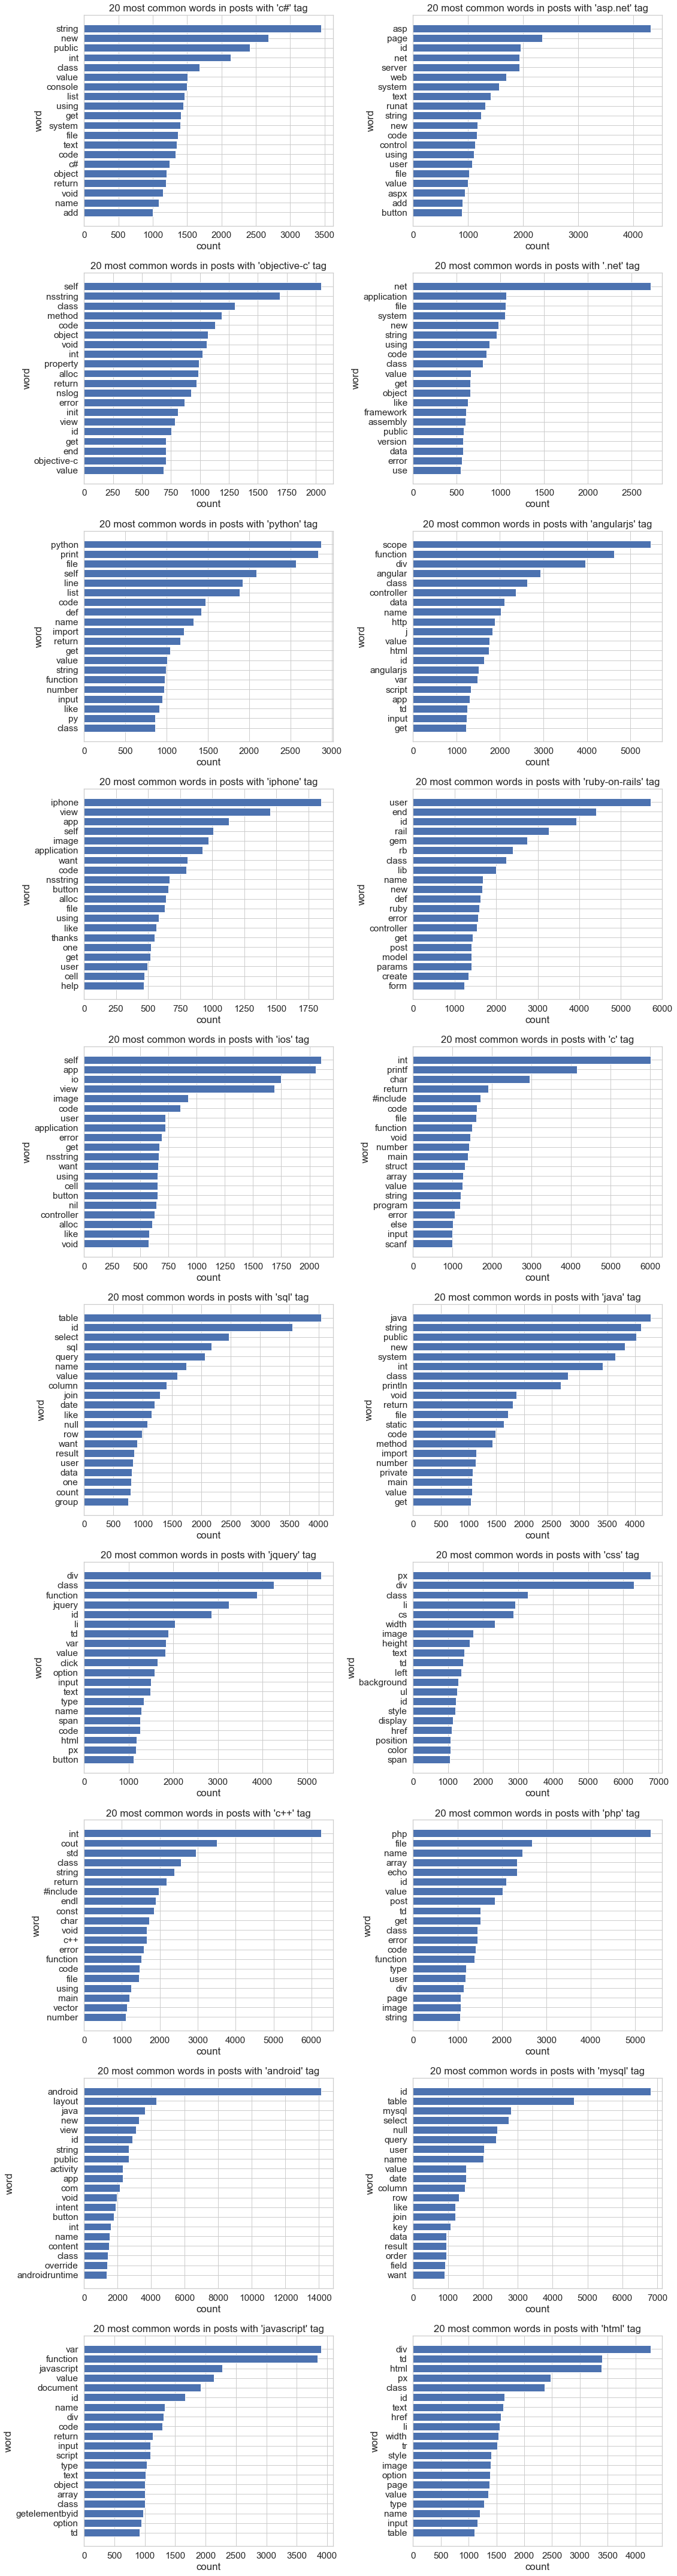

In [16]:
tag_list = list(df['tags'].unique())

fig, axes = plt.subplots(10, 2, figsize=(16, 60))
axes = axes.ravel()
for i, tag in enumerate(tag_list):
    fdist = Counter(' '.join(row for row in df['post_cleaned'][df['tags']==tag]).split()).most_common(20)
    word = [freq[0] for freq in fdist]
    count = [freq[1] for freq in fdist]
    word_pos = [pos for pos, _ in enumerate(word)]
    
    plt.sca(axes[i])
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel("word")
    plt.xlabel("count")
    plt.title("20 most common words in posts with '{}' tag".format(tag))
    plt.gca().invert_yaxis() # invert y axis to descending order
plt.tight_layout()
plt.show()

Just based on the raw frequency of words, some words are more common in questions about a certain language than others. Some other words are common across all posts. In the pipelines below, tf-idf vectors will be used to weight raw frequency by how often words occur across all posts.

### modeling using tfidf as features

In [17]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['post_cleaned'],
                                                    df['tags'],
                                                    test_size=0.3,
                                                    random_state=42)

In [34]:
# classifier dict - using pretty much all default parameters here as first look at model performance
classifiers = {'naive bayes': MultinomialNB(),
               'logistic regression': LogisticRegression(random_state=1),
               'svc (linear kernel)': SVC(kernel='linear', random_state=1),
               'random forest': RandomForestClassifier(n_estimators=100, random_state=1),
               'xgboost': XGBClassifier()}

# make pipelines for all classifiers
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2))),
                                ('dim_red', SelectKBest(chi2, k=1000)), # select 1000 best features
                                ('clf', classifier)])

In [35]:
# function to get cross validation scores - return mean and std of accuracy
def cv_scores(estimator, X_train, y_train, cv):
    scores = {}
    cv_results = cross_validate(estimator, X_train, y_train, cv=cv, return_train_score=False)
    scores['cv_accuracy_mean'] = np.mean(cv_results['test_score'])
    scores['cv_accuracy_std'] = np.std(cv_results['test_score'])
    return scores

In [36]:
# get cv scores for all classifiers
cv_scores_all = []
for name, pipeline in pipelines.items():
    print('fitting {}...'.format(name))
    scores = cv_scores(pipeline, X_train, y_train, 5)
    cv_scores_all.append(scores)

fitting naive bayes...
fitting logistic regression...


C:\Users\nalgn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nalgn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\nalgn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nalgn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\nalgn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

fitting svc (linear kernel)...
fitting random forest...
fitting xgboost...


In [37]:
# save cv scores of differnt classifiers into a dataframe
classifiers = classifiers.keys()
df_cv_scores = pd.DataFrame(cv_scores_all, index=classifiers)
df_cv_scores

,accuracy_mean,accuracy_std
naive bayes,0.743285,0.003684
logistic regression,0.767929,0.001616
svc (linear kernel),0.760215,0.002516
random forest,0.789679,0.003458
xgboost,0.788679,0.001507


### hyperparameter tuning models with better performance

In [39]:
classifiers_tune = {'logistic regression': LogisticRegression(random_state=1),
                    'svc (linear kernel)': SVC(kernel='linear', random_state=1),
                    'random forest': RandomForestClassifier(random_state=1),
                    'xgboost': XGBClassifier()}

pipelines_tune = {}
for name, classifier in classifiers_tune.items():
    pipelines_tune[name] = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2))),
                                     ('dim_red', SelectKBest(chi2)), 
                                     ('clf', classifier)])

In [67]:
# function to tune hyperparameters, print best model results, and return predictions
def hyperparameter_tuning(clf_name, estimator, param_grid, n_iter):
    print('tuning {}...'.format(clf_name))
    rs_cv = RandomizedSearchCV(estimator, param_grid,
                               scoring='accuracy', cv=5,
                               verbose=1, n_jobs=-1, n_iter=n_iter)
    rs_cv.fit(X_train, y_train)
    y_pred = rs_cv.predict(X_test)
    print('{} hyperparameter tuning results:'.format(clf_name))
    print('best parameter set: %s' % rs_cv.best_params_)
    print('mean cv accuracy: %.3f' % rs_cv.best_score_)
    print('test accuracy: %.3f' %rs_cv.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    return y_pred

#### hyperparameter tuning logistic regression

In [65]:
# log regression parameter grid
param_grid_lr = {'dim_red__k': [1000, 2000, 3000, 4000, 5000],
                 'clf__penalty': ['l1', 'l2'],
                 'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0]}

y_pred_lr = hyperparameter_tuning('logistic regression', pipelines_tune['logistic regression'], param_grid_lr, 20)

tuning logistic regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished


logistic regression hyperparameter tuning results:
best parameter set: {'dim_red__k': 4000, 'clf__penalty': 'l2', 'clf__C': 10.0}
mean cv accuracy: 0.803
test accuracy: 0.809
               precision    recall  f1-score   support

         .net       0.76      0.67      0.71       613
      android       0.95      0.92      0.93       620
    angularjs       0.96      0.95      0.96       587
      asp.net       0.83      0.81      0.82       586
            c       0.81      0.87      0.84       599
           c#       0.62      0.64      0.63       589
          c++       0.86      0.77      0.81       594
          css       0.83      0.89      0.86       610
         html       0.72      0.74      0.73       617
          ios       0.65      0.65      0.65       587
       iphone       0.67      0.65      0.66       611
         java       0.89      0.86      0.88       594
   javascript       0.78      0.80      0.79       619
       jquery       0.86      0.86      0.86       574

#### hyperparameter tuning support vector classifier (linear kernel)

In [68]:
# support vector classifier parameter grid
param_grid_svc = {'dim_red__k': [1000, 2000, 3000, 4000, 5000],
                  'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0]}

y_pred_svc = hyperparameter_tuning('support vector classifier', pipelines_tune['svc (linear kernel)'], param_grid_svc, 10)

tuning support vector classifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 43.6min finished


support vector classifier hyperparameter tuning results:
best parameter set: {'dim_red__k': 2000, 'clf__C': 10.0}
mean cv accuracy: 0.785
test accuracy: 0.792
               precision    recall  f1-score   support

         .net       0.71      0.66      0.68       613
      android       0.94      0.89      0.91       620
    angularjs       0.96      0.95      0.96       587
      asp.net       0.82      0.79      0.80       586
            c       0.76      0.86      0.81       599
           c#       0.51      0.66      0.57       589
          c++       0.83      0.74      0.78       594
          css       0.83      0.88      0.85       610
         html       0.70      0.73      0.71       617
          ios       0.63      0.65      0.64       587
       iphone       0.67      0.62      0.64       611
         java       0.91      0.82      0.87       594
   javascript       0.78      0.76      0.77       619
       jquery       0.86      0.85      0.85       574
        mysql  

#### hyperparameter tuning random forest

In [69]:
# random forest parameter grid
param_grid_rf = {'dim_red__k': [1000, 2000, 3000, 4000],
                 'clf__n_estimators': [100, 200, 400, 800],
                 'clf__max_depth': [5, 8, 15, 25, 30, None],
                 'clf__min_samples_split': [2, 5, 10, 15],
                 'clf__min_samples_leaf': [1, 2, 5, 10]}

y_pred_rf = hyperparameter_tuning('random forest', pipelines_tune['random forest'], param_grid_rf, 20)

tuning random forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.1min finished


random forest hyperparameter tuning results:
best parameter set: {'dim_red__k': 1000, 'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': None}
mean cv accuracy: 0.790
test accuracy: 0.794
               precision    recall  f1-score   support

         .net       0.69      0.67      0.68       613
      android       0.95      0.87      0.91       620
    angularjs       0.97      0.97      0.97       587
      asp.net       0.80      0.78      0.79       586
            c       0.76      0.86      0.80       599
           c#       0.56      0.62      0.59       589
          c++       0.83      0.75      0.79       594
          css       0.79      0.89      0.84       610
         html       0.71      0.63      0.67       617
          ios       0.66      0.66      0.66       587
       iphone       0.65      0.62      0.64       611
         java       0.89      0.81      0.85       594
   javascript       0.77      0.78      0.78  

Accuracy for C# is consistently low across classifiers. Next step would be to look at correct and incorrect predictions about C# to see why. Also, posts typically include both questions/descriptions of problems and code snippets. Need to think more about how to capture the syntax of different languages. With the current preprocessing, a lot of the syntactic features of languages are not kept. Could also possibly include metadata such as length of posts (given some languages are more verbose than others) as additional features.

In [ ]:
# xgboost
#param_grid_xgb = {'dim_red__k': [1000, 2000, 3000, 4000, 5000],
#                  'clf__max_depth': [3, 5, 7, 9, 12, 15, 20],
#                 'clf__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
#                 'clf__n_estimators': [100, 200, 400, 600, 800],
#                 'clf__gamma': [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
#                 'clf__min_child_weight': [1, 3, 5, 7],
#                 'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#                 'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#                 'clf__reg_alpha': [0, 0.1, 0.5, 1.0],
#                 'clf__reg_lambda': [0.01, 0.1, 1.0]}
#y_pred_xgb = hyperparameter_tuning('xgboost', pipelines_tune['xgboost'], param_grid_xgb, 30)